###  Business Use Case:

As an MLAI practitioner we are tasked to compare the performance of the classifiers `KNeighborsClassifier()` | `LogisticRegression()` | `DecisionTreeClassifier()` | and `SVC()` in the context of Portuguese banking institution dataset detailing bank’s marketing campaigns to facilitate subscription to a term deposit. Summary of findings related to AI models’ performance along with data analysis, pre-processing, modeling, and business conclusions are expected as deliverables of this exercise.

### Findings | Actionable Insights | Recommendations:

<font color="blue">Models Comparison: Based on the trade-offs between accuracy, precision, recall, and computational efficiency, we can choose the following classifiers (please review the summary dataframe at the very bottom of the notebook)</font>:
- If we prioritize accuracy score, banking institution should choose `KNeighborsClassifier()` or ` DecisionTreeClassifier()` models
- If we prioritize precision and computational efficiency, `DecisionTreeClassifier()` will shine the most, and
- If achieving a high recall is a priority and longer training times and computational resources are not of major concern, then `SVC()` model would be the model of choice

<font color="blue">Observations related to data understanding, pre-processing, and modeling (dive into code and code comments below)</font>:
  - We have 17 features, 10 of which are of object type
  - It appeared that 'default', 'housing', and 'loan' features are suitable for binary encoding using `OneHotEncoder()`
  - After using `OneHotEncoder()`, 7 columns remained to be of object type
  - It appeared that 'job', 'marital', 'education', and 'contact' features are suitable candidates for label encoding using `LabelEncoder()` (we will treat the data points as ordinal categorical data)
  - After using `LabelEncoder()`, 3 columns remained to be of object type, one of which is the target variable 'y_yes'
  - Dropped 'poutcome' with 65% of 'unknown' values and 'month' as features of low relevance; now only one column 'y_yes' remained to be categorical, which is totally okay since it is a target/output variable
  - Overall, 39,922 prospective clients (88.3%) out of the entire sample population (45,211 data points) did not subscribe to a term deposit as derived from past observations
  - It appeared that ‘duration’ (last contact in seconds), ‘pdays’ (number of days passed by after the contact), and ‘previous’ (number of contacts performed during last campaigns) are the most influential factors affecting the subscription to a term deposit
  - Correlation matrix of features also confirmed that ‘duration’ (last contact in seconds) has the biggest impact on oucome variable 'y_yes'
  - Pairplot suggested that data are not evenly distributed, hinting at the need for scaling the data when we will come to data modeling, classifier fitting stage
  - The scatterplot of two most influential features on term deposit suggests that most decisions were made with a duration of the contact up to 25 min (1500/60 sec) and within 1.2 years (450 days / 365 days) since the last marketing campaign
  
<font color="blue">Recommendations for increasing subscriptions to term deposits and making accurate predictions</font>:
  - Marketing team should focus efforts on keeping duration of the contact within 10 – 20 min range
  - Meaningful commitment should be made to staying in touch with prospective clientele at least once annually
  - AI model should be chosen based the trade-offs between accuracy, precision, recall, and computational efficiency as outlined in 'Model Comparison' section above

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

import warnings
warnings.filterwarnings("ignore")

from ucimlrepo import fetch_ucirepo # just in case if we would like to load data directly from the UCI server

In [ ]:
# # fetching dataset from UCI server 
# bank_marketing = fetch_ucirepo(id=222)
# # data (as pandas dataframes) 
# X = bank_marketing.data.features 
# y = bank_marketing.data.targets

In [2]:
# loading dataset as a dataframe from local folder
bank_marketing = pd.read_csv('C:/Users/iheaven/jupiterNotebook/practicalApplication_v03/data/bank-full.csv', sep=';')

In [3]:
# starting exploratory data analysis 
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# peeking into columns containing categorical values in order to evaluate encoding strategy
object_columns = bank_marketing.select_dtypes(include=['object'])
object_columns

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no
...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,nov,unknown,yes
45207,retired,divorced,primary,no,no,no,cellular,nov,unknown,yes
45208,retired,married,secondary,no,no,no,cellular,nov,success,yes
45209,blue-collar,married,secondary,no,no,no,telephone,nov,unknown,no


In [5]:
# identifying the quantity of unique values in each categorical column to further evaluate encoding strategy
for column in object_columns.columns:
    # calculating the number of unique values in each column
    unique_values_count = object_columns[column].nunique()
    
    print(f"categorical column '{column}' has {unique_values_count} unique value(s)")

categorical column 'job' has 12 unique value(s)
categorical column 'marital' has 3 unique value(s)
categorical column 'education' has 4 unique value(s)
categorical column 'default' has 2 unique value(s)
categorical column 'housing' has 2 unique value(s)
categorical column 'loan' has 2 unique value(s)
categorical column 'contact' has 3 unique value(s)
categorical column 'month' has 12 unique value(s)
categorical column 'poutcome' has 4 unique value(s)
categorical column 'y' has 2 unique value(s)


the attemp to understand the structure of the data suggests the following data preparation tasks:
1. using OneHotEncoder() to binarize 'default', 'housing', and 'loan' features
2. using LabelEncoder() to encode 'job', 'marital', 'education', 'contact' (we will treat the data as ordinal categorical data points)
3. drop 'poutcome' (since it contains 29569 - 65% unknown values) and 'month' (we will treat this feature as irrelevant)

In [6]:
# it appears that 'default', 'housing', and 'loan' features might be good candidate for binary encoding using OneHotEncoder()
bank_marketing[['default', 'housing', 'loan', 'y']]

,default,housing,loan,y
0,no,yes,no,no
1,no,yes,no,no
2,no,yes,yes,no
3,no,yes,no,no
4,no,no,no,no
...,...,...,...,...
45206,no,no,no,yes
45207,no,no,no,yes
45208,no,no,no,yes
45209,no,no,no,no


In [7]:
'''investigate how to modify a dataframe columns where we use OneHotEncoder() for  [default, housing, loan] columns,
using LabelEncoder() for [job, marital, education, contact] columns and dropping [month, poutcome] columns all in one step'''

'investigate how to modify a dataframe columns where we use OneHotEncoder() for  [default, housing, loan] columns,\nusing LabelEncoder() for [job, marital, education, contact] columns and dropping [month, poutcome] columns all in one step'

In [7]:
# initializing OneHotEncoder()
one_hot_encoder = OneHotEncoder(drop='if_binary')
# identifying columns to be encoded
columns_to_encode = ['default', 'housing', 'loan', 'y']
# encoding
for column in columns_to_encode:
    # reshaping the column to a 2D array
    encoded_values = one_hot_encoder.fit_transform(bank_marketing[[column]])
    # converting the sparse matrix into a dataframe and concatenating it back to bank_marketing
    encoded_df = pd.DataFrame(encoded_values.toarray(), columns=one_hot_encoder.get_feature_names_out([column]))
    bank_marketing = pd.concat([bank_marketing, encoded_df], axis=1)
    # dropping the original, un-encoded columns
    bank_marketing.drop(column, axis=1, inplace=True)

In [8]:
# checking if OneHotEncoder() did the job ... yep, things look good!
bank_marketing[['default_yes', 'housing_yes', 'loan_yes', 'y_yes']]

,default_yes,housing_yes,loan_yes,y_yes
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0
...,...,...,...,...
45206,0.0,0.0,0.0,1.0
45207,0.0,0.0,0.0,1.0
45208,0.0,0.0,0.0,1.0
45209,0.0,0.0,0.0,0.0


In [9]:
# checking the entegrity of the entire dataframe after using OneHotEncoder() ... yep, looks good!
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          45211 non-null  int64  
 1   job          45211 non-null  object 
 2   marital      45211 non-null  object 
 3   education    45211 non-null  object 
 4   balance      45211 non-null  int64  
 5   contact      45211 non-null  object 
 6   day          45211 non-null  int64  
 7   month        45211 non-null  object 
 8   duration     45211 non-null  int64  
 9   campaign     45211 non-null  int64  
 10  pdays        45211 non-null  int64  
 11  previous     45211 non-null  int64  
 12  poutcome     45211 non-null  object 
 13  default_yes  45211 non-null  float64
 14  housing_yes  45211 non-null  float64
 15  loan_yes     45211 non-null  float64
 16  y_yes        45211 non-null  float64
dtypes: float64(4), int64(7), object(6)
memory usage: 5.9+ MB


In [10]:
# moving further with EDA: it appears that 'job', 'marital', 'education', and 'contact' features might be good candidate for label encoding using LabelEncoder()
bank_marketing[['job', 'marital', 'education', 'contact']]

,job,marital,education,contact
0,management,married,tertiary,unknown
1,technician,single,secondary,unknown
2,entrepreneur,married,secondary,unknown
3,blue-collar,married,unknown,unknown
4,unknown,single,unknown,unknown
...,...,...,...,...
45206,technician,married,tertiary,cellular
45207,retired,divorced,primary,cellular
45208,retired,married,secondary,cellular
45209,blue-collar,married,secondary,telephone


In [11]:
# initializing LabelEncoder()
label_encoder = LabelEncoder()
# identifying columns to be encoded
columns_for_encoder = ['job', 'marital', 'education', 'contact']
# encoding
for column in columns_for_encoder: bank_marketing[column] = label_encoder.fit_transform(bank_marketing[column])

In [12]:
# checking if LabelEncoder() did the job ... yep, things look good!
bank_marketing[['job', 'marital', 'education', 'contact']]

,job,marital,education,contact
0,4,1,2,2
1,9,2,1,2
2,2,1,1,2
3,1,1,3,2
4,11,2,3,2
...,...,...,...,...
45206,9,1,2,0
45207,5,0,0,0
45208,5,1,1,0
45209,1,1,1,1


In [13]:
# checking the entegrity of the entire dataframe fter using LabelEncoder() ... yep, looks good!
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          45211 non-null  int64  
 1   job          45211 non-null  int32  
 2   marital      45211 non-null  int32  
 3   education    45211 non-null  int32  
 4   balance      45211 non-null  int64  
 5   contact      45211 non-null  int32  
 6   day          45211 non-null  int64  
 7   month        45211 non-null  object 
 8   duration     45211 non-null  int64  
 9   campaign     45211 non-null  int64  
 10  pdays        45211 non-null  int64  
 11  previous     45211 non-null  int64  
 12  poutcome     45211 non-null  object 
 13  default_yes  45211 non-null  float64
 14  housing_yes  45211 non-null  float64
 15  loan_yes     45211 non-null  float64
 16  y_yes        45211 non-null  float64
dtypes: float64(4), int32(4), int64(7), object(2)
memory usage: 5.2+ MB


In [14]:
# finally dropping 'poutcome' with 65% 'unknown' values and 'month' features
bank_marketing.drop(['poutcome', 'month'], axis=1, inplace=True)

In [15]:
# checking the entegrity of the entire dataframe after dropping 'poutcome' and 'month' ... yep, looks good!
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          45211 non-null  int64  
 1   job          45211 non-null  int32  
 2   marital      45211 non-null  int32  
 3   education    45211 non-null  int32  
 4   balance      45211 non-null  int64  
 5   contact      45211 non-null  int32  
 6   day          45211 non-null  int64  
 7   duration     45211 non-null  int64  
 8   campaign     45211 non-null  int64  
 9   pdays        45211 non-null  int64  
 10  previous     45211 non-null  int64  
 11  default_yes  45211 non-null  float64
 12  housing_yes  45211 non-null  float64
 13  loan_yes     45211 non-null  float64
 14  y_yes        45211 non-null  float64
dtypes: float64(4), int32(4), int64(7)
memory usage: 4.5 MB


In [16]:
# observation: 39,922 (88.3%) out of entire dataset (45,211 data points) did not subscribe to a term deposit 
print(bank_marketing.y_yes.value_counts())
print(bank_marketing.y_yes.value_counts(normalize=True))

y_yes
0.0    39922
1.0     5289
Name: count, dtype: int64
y_yes
0.0    0.883015
1.0    0.116985
Name: proportion, dtype: float64


<Axes: >

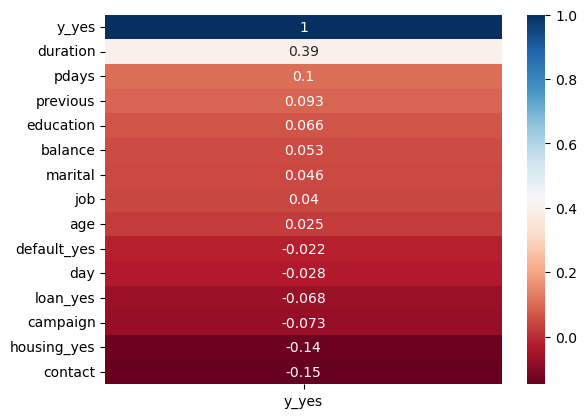

In [17]:
# let's discover which featues has a biggest impact on 'y_yes'
sns.heatmap(bank_marketing.corr()[['y_yes']].sort_values(by = 'y_yes', ascending = False), annot = True, cmap="RdBu")

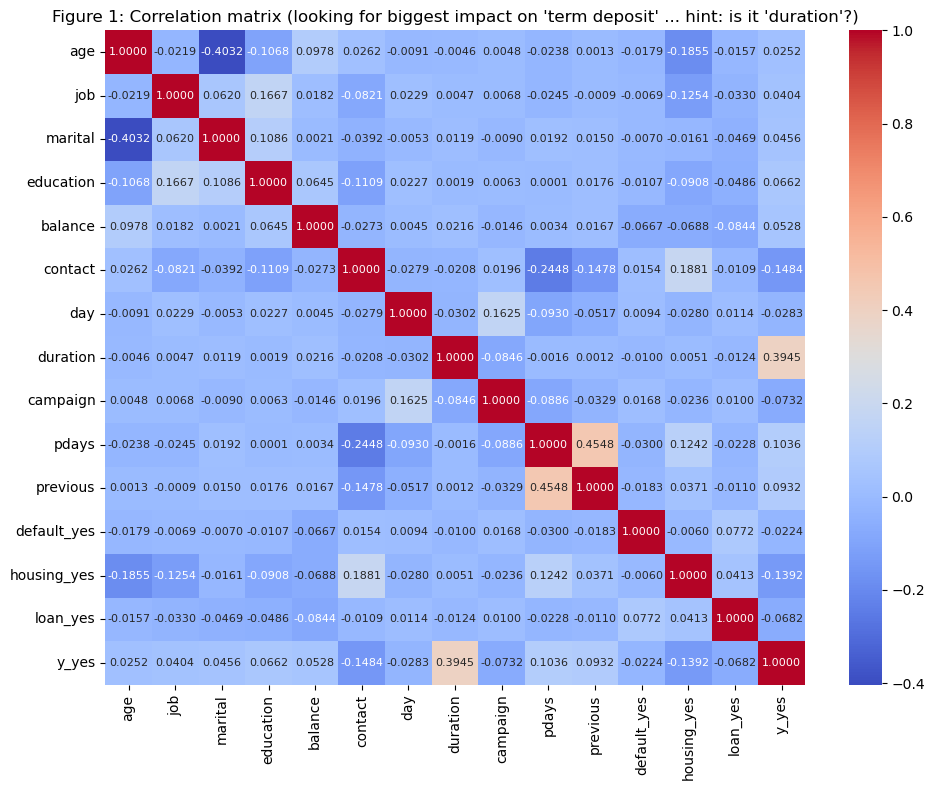

In [18]:
# investigating further which featues has a biggest impact on 'y_yes' (target variable)
corr_matrix = bank_marketing[bank_marketing.columns.tolist()].corr()
# setting up the matplotlib figure
plt.figure(figsize=(10, 8))
# plotting the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f", annot_kws={"size": 8})
plt.title("Figure 1: Correlation matrix (looking for biggest impact on 'term deposit' ... hint: is it 'duration'?)")
plt.tight_layout()
plt.show()

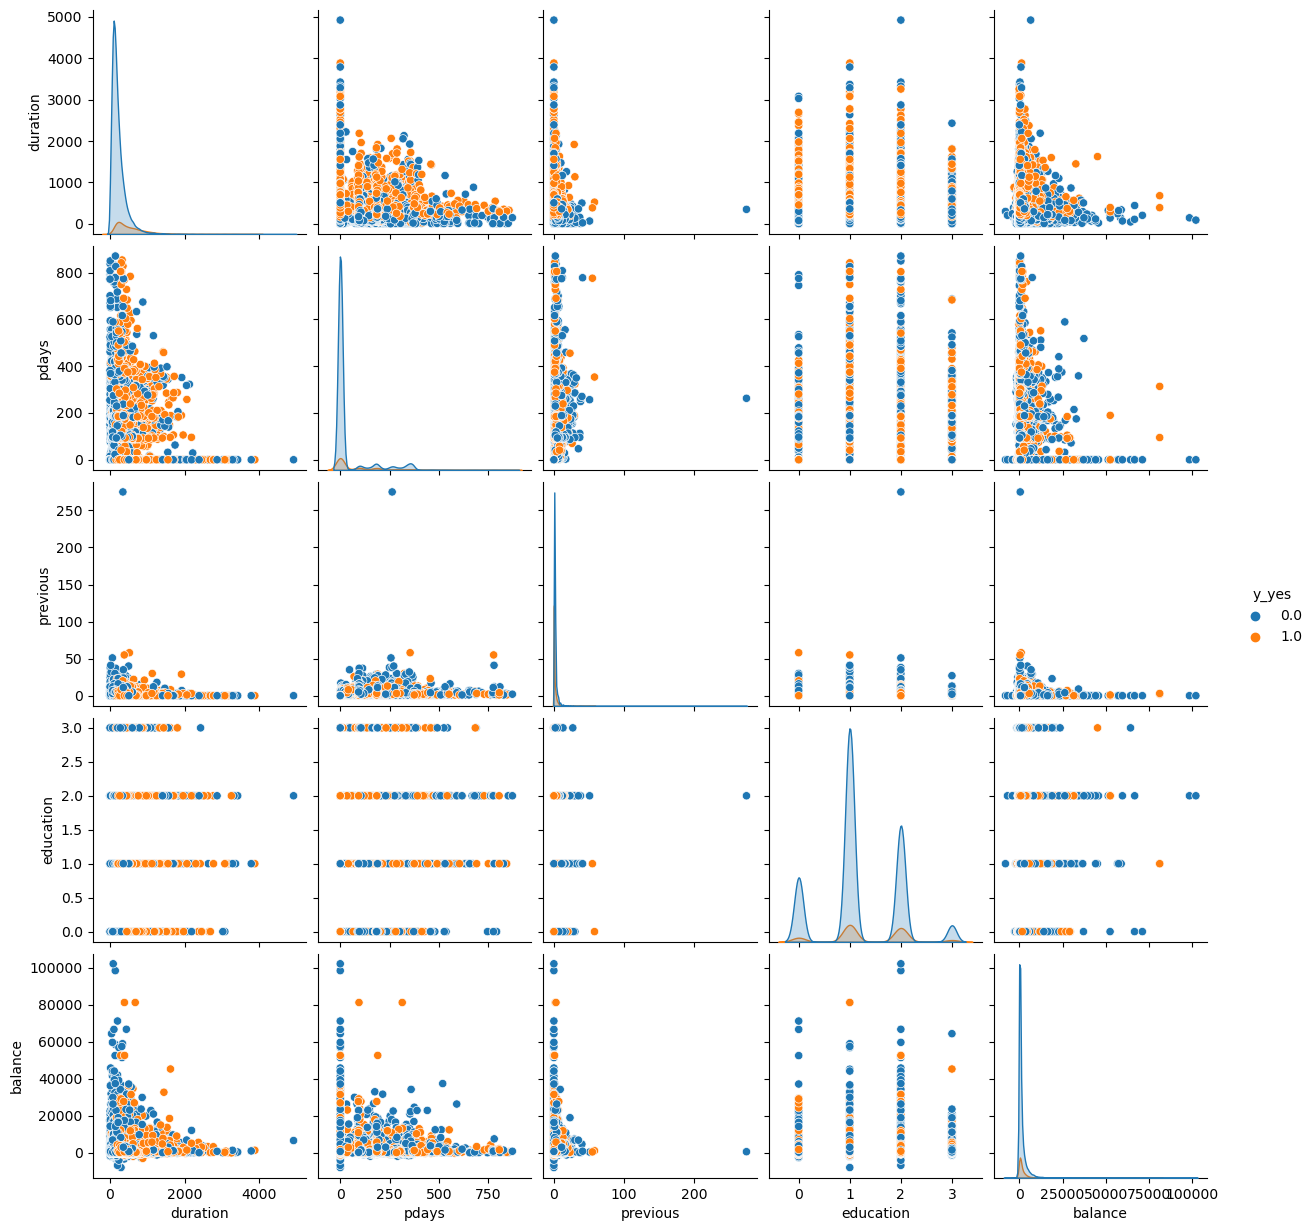

In [19]:
# building a pairplot based on five most impactful features
sns.pairplot(bank_marketing[['duration', 'pdays', 'previous', 'education', 'balance', 'y_yes']], hue = 'y_yes')

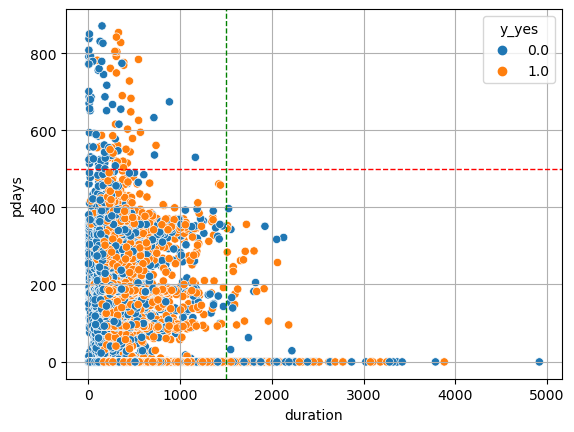

In [20]:
# reviewing the distribution of most influencial features
sns.scatterplot(data = bank_marketing, x = 'duration', y='pdays', hue='y_yes')
plt.axhline(y=500, color='r', linestyle='--', linewidth=1)
plt.axvline(x=1500, color='g', linestyle='--', linewidth=1)
plt.grid(True)

In [21]:
# splitting the data into training 80% and testing 20% sets
X_train, X_test, y_train, y_test = train_test_split(bank_marketing.drop('y_yes', axis = 1), bank_marketing['y_yes'], test_size=0.2, random_state=71)

In [22]:
# confirming expected output after data split

print(X_train.sample(), type(X_train))
print(y_train.sample(), type(y_train))

print(X_train.shape, y_train.shape)
print(' should be 80% of 45211 - and it is! \n' )
print(X_test.shape, y_test.shape)
print(' should be 20% of 45211 - and it is! \n' )

      age  job  marital  education  balance  contact  day  duration  campaign  \
2229   31    1        0          1      387        2   12       220         3   

      pdays  previous  default_yes  housing_yes  loan_yes  
2229     -1         0          0.0          1.0       0.0   <class 'pandas.core.frame.DataFrame'>
5231    0.0
Name: y_yes, dtype: float64 <class 'pandas.core.series.Series'>
(36168, 14) (36168,)
 should be 80% of 45211 - and it is! 

(9043, 14) (9043,)
 should be 20% of 45211 - and it is! 



In [21]:
# conducting GridSearchCV() to obtain best parameters for KNeighborsClassifier() ... takes a bit to run! (10-15 min)
knn_pipe = Pipeline([('scale', StandardScaler()), ('model', KNeighborsClassifier())])
params = {'model__n_neighbors': list(range(1, 22, 2)), 'model__weights': ['uniform', 'distance'], 'model__p': [1, 2]}
knn_grid = GridSearchCV(knn_pipe, param_grid=params).fit(X_train, y_train)
knn_grid.best_params_

{'model__n_neighbors': 19, 'model__p': 1, 'model__weights': 'distance'}

In [23]:
# performing data modeling using KNeighborsClassifier()
start_time_knn = time.time()

knn = Pipeline([('scale', StandardScaler()), ('model', KNeighborsClassifier(n_neighbors=19, weights='distance', p=1))]).fit(X_train, y_train)
# score = knn.score(X_test, y_test) ... this can be removed in final draft
y_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, y_pred)
knn_precision = precision_score(y_test, y_pred, pos_label=0.0)
knn_recall = recall_score(y_test, y_pred, pos_label=0.0)

end_time_knn = time.time()
time_taken_knn = end_time_knn - start_time_knn

print("Time taken:", time_taken_knn, "seconds")
# print("KNeighborsClassifier score:", score) ... this can be removed in final draft
print("KNeighborsClassifier accuracy score:", knn_accuracy)
print("KNeighborsClassifier precision score:", knn_precision)
print("KNeighborsClassifier recall score:", knn_recall)

Time taken: 8.139499425888062 seconds
KNeighborsClassifier accuracy score: 0.8979321021784806
KNeighborsClassifier precision score: 0.9087767795438839
KNeighborsClassifier recall score: 0.9836678718364293


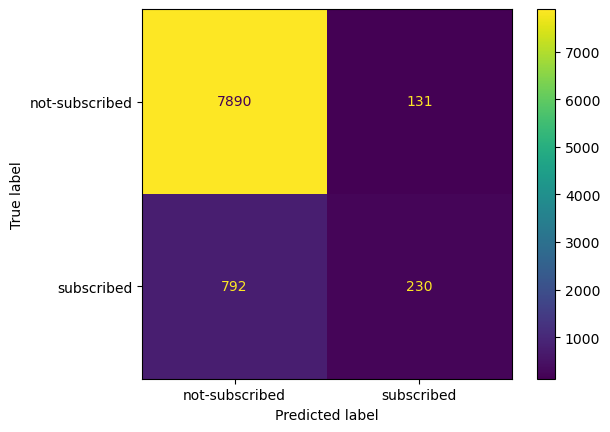

In [24]:
knn_confusion_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_confusion_mat, display_labels=['not-subscribed', 'subscribed'])
disp.plot()
plt.show()

In [25]:
# conducting GridSearchCV() to obtain best parameters for LogisticRegression() ... runs fairly quickly (few min)
log_pipe = Pipeline([('logmodel', LogisticRegression())])
logparams = {'logmodel__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logmodel__penalty': ['l1', 'l2'], 'logmodel__solver': ['liblinear', 'saga']}
knn_grid = GridSearchCV(log_pipe, param_grid=logparams).fit(X_train, y_train)
knn_grid.best_params_

{'logmodel__C': 100,
 'logmodel__penalty': 'l2',
 'logmodel__solver': 'liblinear'}

In [25]:
# performing data modeling using LogisticRegression()
start_time_logistic = time.time()

logreg = LogisticRegression(C=100, solver='liblinear').fit(X_train, y_train)
preds = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, preds)
logreg_precision = precision_score(y_test, preds, pos_label=0.0)
logreg_recall = recall_score(y_test, preds, pos_label=0.0)

end_time_logistic = time.time()
time_taken_logistic = end_time_logistic - start_time_logistic

print("Time taken:", time_taken_logistic, "seconds")
print("LogisticRegression accuracy score:", logreg_accuracy)
print("LogisticRegression precision score:", logreg_precision)
print("LogisticRegression recall score:", logreg_recall)

Time taken: 0.4183349609375 seconds
LogisticRegression accuracy score: 0.893177043016698
LogisticRegression precision score: 0.9067220108382336
LogisticRegression recall score: 0.9804263807505299


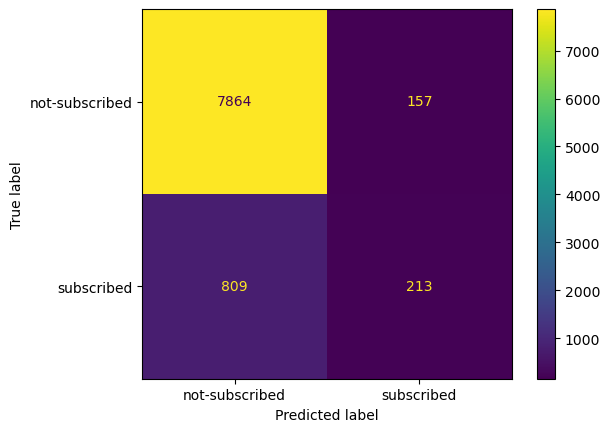

In [26]:
logreg_confusion_mat = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=logreg_confusion_mat, display_labels=['not-subscribed', 'subscribed'])
disp.plot()
plt.show()

In [30]:
# conducting GridSearchCV() to obtain best parameters for DecisionTreeClassifier() ... runs fairly quickly (few min)
tree_pipe = Pipeline([('treemodel', DecisionTreeClassifier())])
treeparams = {'treemodel__criterion': ['gini', 'entropy'], 'treemodel__max_depth': [3, 5, 10, 15, 20], 'treemodel__min_samples_split': [0.1, 0.2, 0.05], 'treemodel__min_samples_leaf': [1, 2, 4]}
tree_grid = GridSearchCV(tree_pipe, param_grid=treeparams).fit(X_train, y_train)
tree_grid.best_params_

{'treemodel__criterion': 'gini',
 'treemodel__max_depth': 10,
 'treemodel__min_samples_leaf': 1,
 'treemodel__min_samples_split': 0.05}

In [27]:
# performing data modeling using DecisionTreeClassifier()
start_time_tree = time.time()

tree = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split=0.05).fit(X_train, y_train)
preds_tree = tree.predict(X_test)
tree_accuracy = accuracy_score(y_test, preds_tree)
tree_precision = precision_score(y_test, preds_tree, pos_label=0.0)
tree_recall = recall_score(y_test, preds_tree, pos_label=0.0)

end_time_tree = time.time()
time_taken_tree = end_time_tree - start_time_tree

print("Time taken:", time_taken_tree, "seconds")
print("DecisionTreeClassifier accuracy score:", tree_accuracy)
print("DecisionTreeClassifier precision score:", tree_precision)
print("DecisionTreeClassifier recall score:", tree_recall)

Time taken: 0.13860607147216797 seconds
DecisionTreeClassifier accuracy score: 0.8956098639831914
DecisionTreeClassifier precision score: 0.9242297086680255
DecisionTreeClassifier recall score: 0.9611021069692058


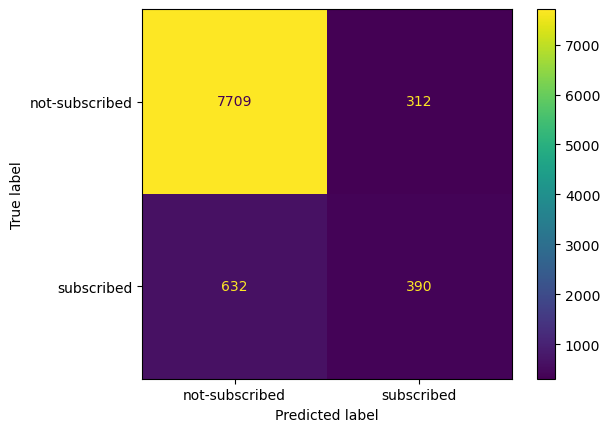

In [28]:
tree_confusion_mat = confusion_matrix(y_test, preds_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=tree_confusion_mat, display_labels=['not-subscribed', 'subscribed'])
disp.plot()
plt.show()

In [ ]:
# conducting GridSearchCV() to obtain best parameters for SVC() ... runs little over 2 hours!!!
# svc_pipe = Pipeline([('svcmodel', SVC())])
svc_pipe = Pipeline([('scale', StandardScaler()), ('svcmodel', SVC())])
# svcparams = {'svcmodel__C': [0.1, 1, 10, 100], 'svcmodel__gamma': [0.1, 1.0, 10.0, 100.0], 'svcmodel__kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
svcparams = {'svcmodel__kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
svc_grid = GridSearchCV(svc_pipe, param_grid=svcparams).fit(X_train, y_train)
svc_grid.best_params_

In [29]:
# performing data modeling using SVC()
start_time_svc = time.time()

vector = SVC(C=1, kernel='rbf', gamma='scale').fit(X_train, y_train)
preds_vector = vector.predict(X_test)
svc_accuracy = accuracy_score(y_test, preds_vector)
svc_precision = precision_score(y_test, preds_vector, pos_label=0.0)
svc_recall = recall_score(y_test, preds_vector, pos_label=0.0)

end_time_svc = time.time()
time_taken_svc = end_time_svc - start_time_svc

print("Time taken:", time_taken_svc, "seconds")
print("Support Vector Classifier accuracy score:", svc_accuracy)
print("Support Vector Classifier precision score:", svc_precision)
print("Support Vector Classifier recall score:", svc_recall)

Time taken: 35.290244579315186 seconds
Support Vector Classifier accuracy score: 0.8869844078292602
Support Vector Classifier precision score: 0.8875844501052165
Support Vector Classifier recall score: 0.9991272908614885


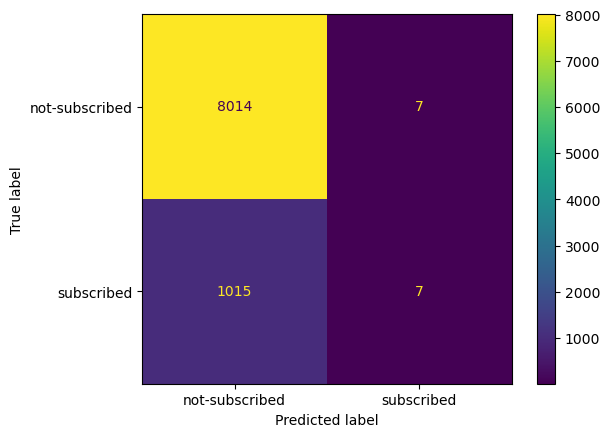

In [30]:
svc_confusion_mat = confusion_matrix(y_test, preds_vector)
disp = ConfusionMatrixDisplay(confusion_matrix=svc_confusion_mat, display_labels=['not-subscribed', 'subscribed'])
disp.plot()
plt.show()

In [31]:
# setting dataframe display opions so that we can see the entire summary at once
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [32]:
# setting up summary of model comparison dataframe and displaying it
res_dict = {'model': ['KNeighborsClassifier()', 'LogisticRegression()', 'DecisionTreeClassifier()', 'SVC()'],
            'time in seconds': [time_taken_knn, time_taken_logistic, time_taken_tree, time_taken_svc],
            'accuracy score': [knn_accuracy, logreg_accuracy, tree_accuracy, svc_accuracy],
            'precision score': [knn_precision, logreg_precision, tree_precision, svc_precision],
            'recall score': [knn_recall, logreg_recall, tree_recall, svc_recall],
            'best parameters':["{'n_neighbors': 19, 'weights': 'distance', 'p': 1}", "{'C': 100, 'solver': 'liblinear'}", "{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 0.05}", "{'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}"]}
results_df = pd.DataFrame(res_dict).set_index('model')
results_df

,time in seconds,accuracy score,precision score,recall score,best parameters
model,,,,,
KNeighborsClassifier(),8.139499,0.897932,0.908777,0.983668,"{'n_neighbors': 19, 'weights': 'distance', 'p': 1}"
LogisticRegression(),0.418335,0.893177,0.906722,0.980426,"{'C': 100, 'solver': 'liblinear'}"
DecisionTreeClassifier(),0.138606,0.895610,0.924230,0.961102,"{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 0.05}"
SVC(),35.290245,0.886984,0.887584,0.999127,"{'C': 1, 'kernel': 'rbf', 'gamma': 'scale'}"
